In [1]:
import anndata as ad
import scanpy as sc
import scvi
import os
import pandas as pd
import numpy as np
import scarches as sca
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/code')
import useful_functions as uf
import sys
print(sys.executable)
import gdown
import torch
import warnings
#warnings
warnings.simplefilter(action='ignore')
#figures
sc.set_figure_params(frameon=False, figsize=(4, 4), dpi=150, fontsize = 5)
#set seeds for reproducibility
scvi.settings.seed = 100
#torch
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

from datetime import datetime
print(datetime.now(tz=None))

/nfs/team297/bs16/tools/conda_envs/scvi-env/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/nfs/team297/bs16/tools/conda_envs/scvi-env/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Global seed set to 0
/nfs/team297/bs16/tools/conda_envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/nfs/team297/bs16/tools/conda_envs/

/nfs/team297/bs16/tools/conda_envs/scvi-env/bin/python3.9


Global seed set to 100


2023-12-15 11:44:37.922101


In [2]:
import warnings
warnings.filterwarnings('ignore')
#this will hide the awful pandas deprec warnings that are currently plaguing scanpy

#now print versions
print(sc.__version__)
print(ad.__version__)
print(scvi.__version__)
print(pd.__version__)
print(np.__version__)
print(sca.__version__)
print(torch.__version__)

1.8.2
0.8.0
0.19.0
1.5.1
1.23.4
0.5.6
1.12.1+cu102


In [3]:
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response')
multiome_adata = sc.read_h5ad("./data/annotated/multiome_adata.h5ad")

In [4]:
def get_counts_raw(adata):
    adata_counts = adata.uns['raw_adata'].copy()
    #adata_counts = adata_counts[adata.obs_names]
    adata = adata.raw.to_adata()
    adata.layers = adata_counts.layers.copy()
    return(adata)
multiome_adata = get_counts_raw(multiome_adata)

In [5]:
multiome_adata = multiome_adata[:, multiome_adata.var['feature_types'].isin(['Gene Expression'])]

In [6]:
#lake nucleus
lake_adata = sc.read_h5ad("./data/public_data/lake_2023/lake_SNrnaseq.h5ad")

In [7]:
multiome_adata.obs['dataset'] = 'stewart'
lake_adata.obs['dataset'] = 'lake'
lake_adata.obs['donor'] = lake_adata.obs['library']

In [8]:
joint_adata = sc.concat([lake_adata, multiome_adata])

In [10]:
# Compute HVG per batch
nvar = 3000
sc.pp.highly_variable_genes(joint_adata, n_top_genes = nvar, flavor='seurat_v3', subset = False, 
                            layer = 'counts',
                           batch_key = 'dataset')
# Sort by how many times a gene is marked as HVG and select top genes
hvg = joint_adata.var.sort_values('highly_variable_nbatches').tail(nvar).index
# Update gene's metadata
joint_adata.var['highly_variable'] = [g in hvg for g in joint_adata.var.index]

In [12]:
joint_adata.uns['raw_adata'] = joint_adata.copy() #this lets us get the rawcounts later

In [13]:
#normalise and log transform
sc.pp.normalize_total(joint_adata)
sc.pp.log1p(joint_adata)
#then we can use raw for plotting

In [14]:
joint_adata.raw = joint_adata.copy()

In [15]:
#subset to HVG
joint_adata = joint_adata[:, joint_adata.var['highly_variable']]


In [16]:
#calculate PCA
sc.pp.pca(joint_adata)

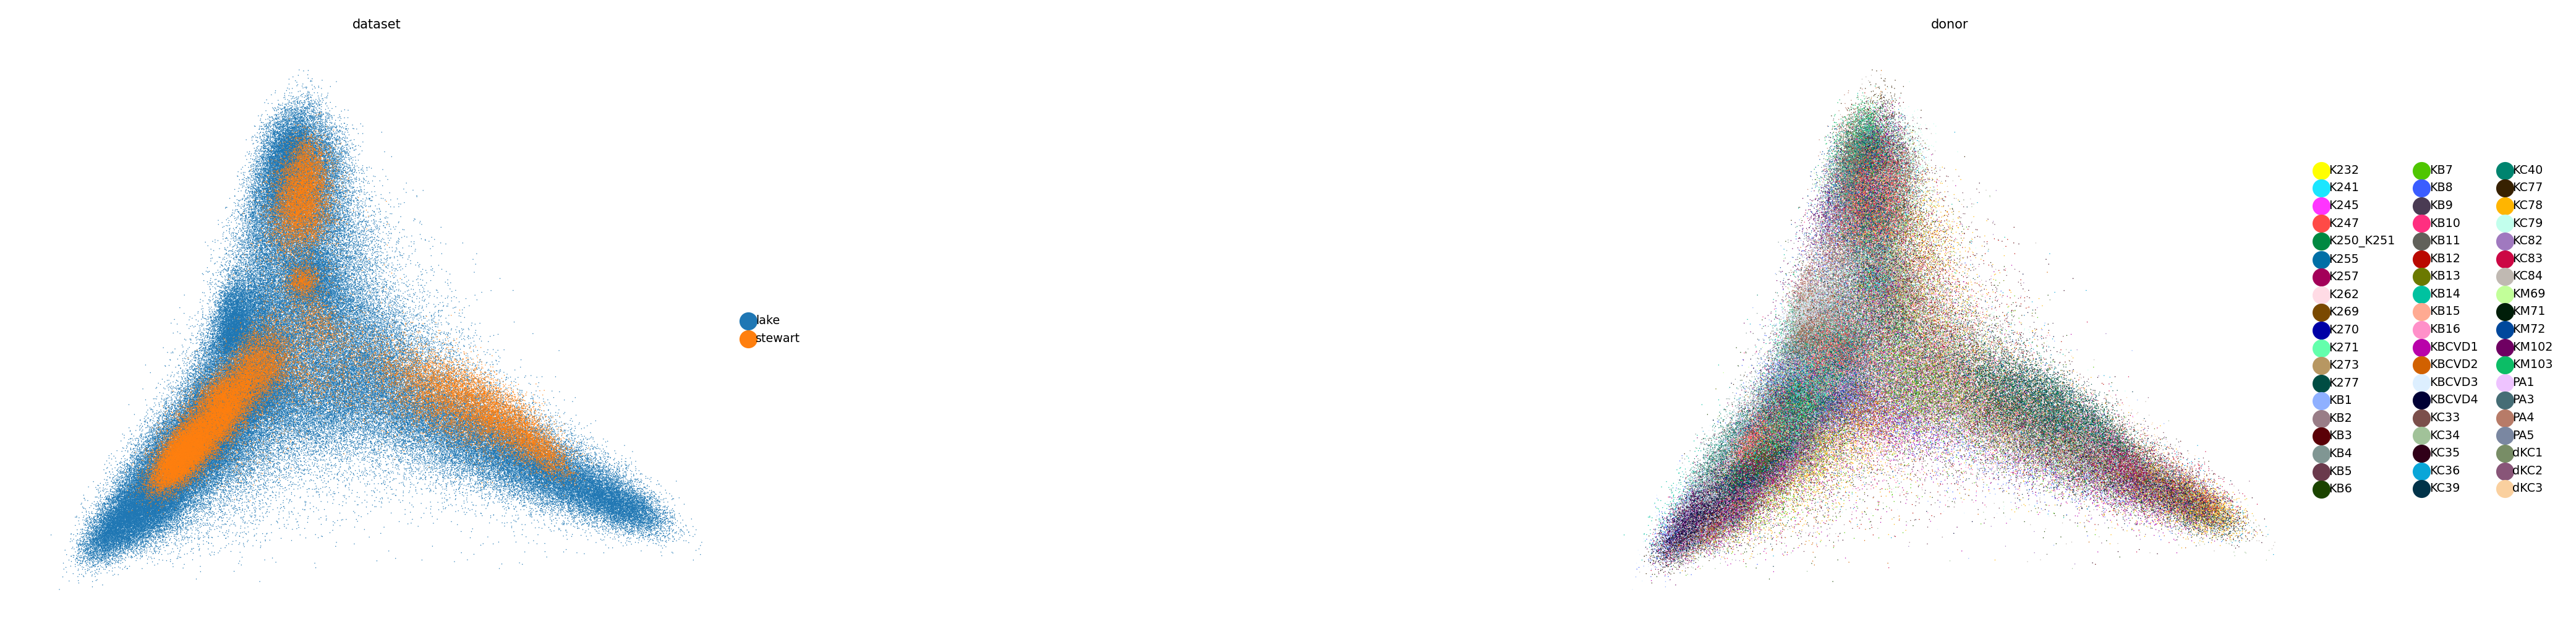

In [17]:
sc.pl.pca(joint_adata, color = ['dataset', 'donor'],
          wspace = 1)

In [18]:
joint_adata = joint_adata.copy()

In [19]:
#setup an SCVI model
scvi.model.SCVI.setup_anndata(joint_adata, 
                           categorical_covariate_keys = ['dataset', 'donor'],
                              layer = 'counts')

In [20]:
vae = sca.models.SCVI(joint_adata, 
                      n_latent =15, 
                      n_layers = 2, 
                encode_covariates=True,
                deeply_inject_covariates=False,
                use_layer_norm="both",
                use_batch_norm="none",

                      gene_likelihood = 'nb')

In [21]:
vae.view_anndata_setup(joint_adata)

Anndata setup with scvi-tools version 0.19.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['dataset', 'donor'],
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │ 255698 │
│ n_extra_categorical_covs │   2    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │  3000  │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │           adata.layers['counts']           │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

           extra_categorical_covs State Registry           
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['dataset'] │    lake    │          0          │
│                      │  stewart   │          1          │
│                      │            │                     │
│  adata.obs['donor']  │    K232    │          0          │
│                      │    K241    │          1          │
│                      │    K245    │          2          │
│                      │    K247    │          3          │
│                      │ K250_K251  │          4          │
│                      │    K255    │          5          │
│                      │    K257    │          6          │
│                      │    K262    │          7          │
│                      │    K269    │          8          │
│                      │    K270    │          9          │
│                      │    K271    │         10          │
│                      │    K273    │         11          │
│                      │    K277    │         12          │
│                      │    KB1     │         13          │
│                      │    KB2     │         14          │
│                      │    KB3     │         15          │
│                      │    KB4     │         16          │
│                      │    KB5     │         17          │
│                      │    KB6     │         18          │
│                      │    KB7     │         19          │
│                      │    KB8     │         20          │
│                      │    KB9     │         21          │
│                      │    KB10    │         22          │
│                      │    KB11    │         23          │
│                      │    KB12    │         24          │
│                      │    KB13    │         25          │
│                      │    KB14    │         26          │
│                      │    KB15    │         27          │
│                      │    KB16    │         28          │
│                      │   KBCVD1   │         29          │
│                      │   KBCVD2   │         30          │
│                      │   KBCVD3   │         31          │
│                      │   KBCVD4   │         32          │
│                      │    KC33    │         33          │
│                      │    KC34    │         34          │
│                      │    KC35    │         35          │
│                      │    KC36    │         36          │
│                      │    KC39    │         37          │
│                      │    KC40    │         38          │
│                      │    KC77    │         39          │
│                      │    KC78    │         40          │
│                      │    KC79    │         41          │
│                      │    KC82    │         42          │
│                      │    KC83    │         43          │
│                      │    KC84    │         44          │
│                      │    KM69    │         45          │
│                      │    KM71    │         46          │
│                      │    KM72    │         47          │
│                      │   KM102    │         48          │
│                      │   KM103    │         49          │
│                      │    PA1     │         50          │
│                      │    PA3     │         51          │
│                      │    PA4     │         52          │
│                      │    PA5     │         53          │
│                      │    dKC1    │         54          │
│                      │    dKC2    │         55          │
│                      │    dKC3    │         56          │
│                      │            │                     │
└──────────────────────┴────────────┴─────────────────────┘

In [22]:
vae.train(early_stopping = True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 31/31: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [12:28<00:00, 23.89s/it, loss=932, v_num=1]

`Trainer.fit` stopped: `max_epochs=31` reached.


Epoch 31/31: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [12:28<00:00, 24.14s/it, loss=932, v_num=1]


In [23]:
joint_adata.obsm['X_scVI'] = vae.get_latent_representation()

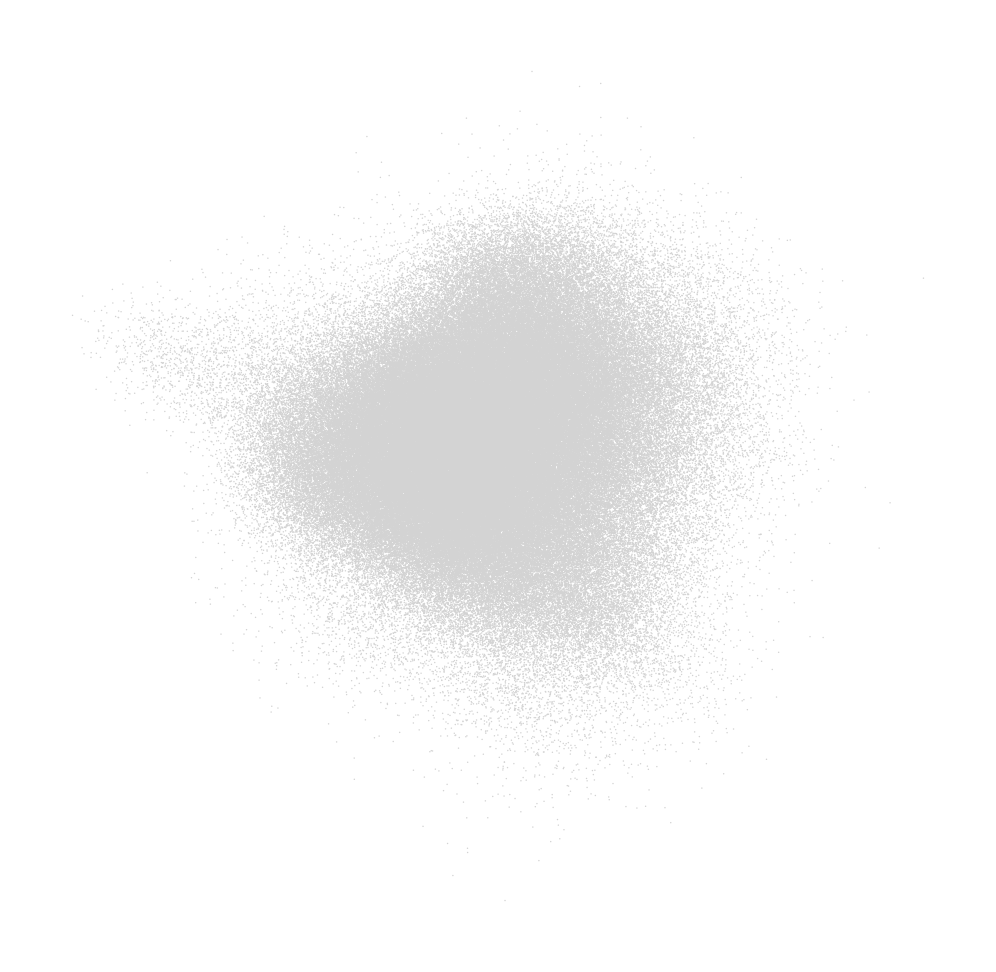

In [24]:
sc.pl.embedding(joint_adata, basis = "X_scVI")

In [25]:
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data/trained/public_data')
vae.save("lake_nuclei/", overwrite=True, save_anndata = True)

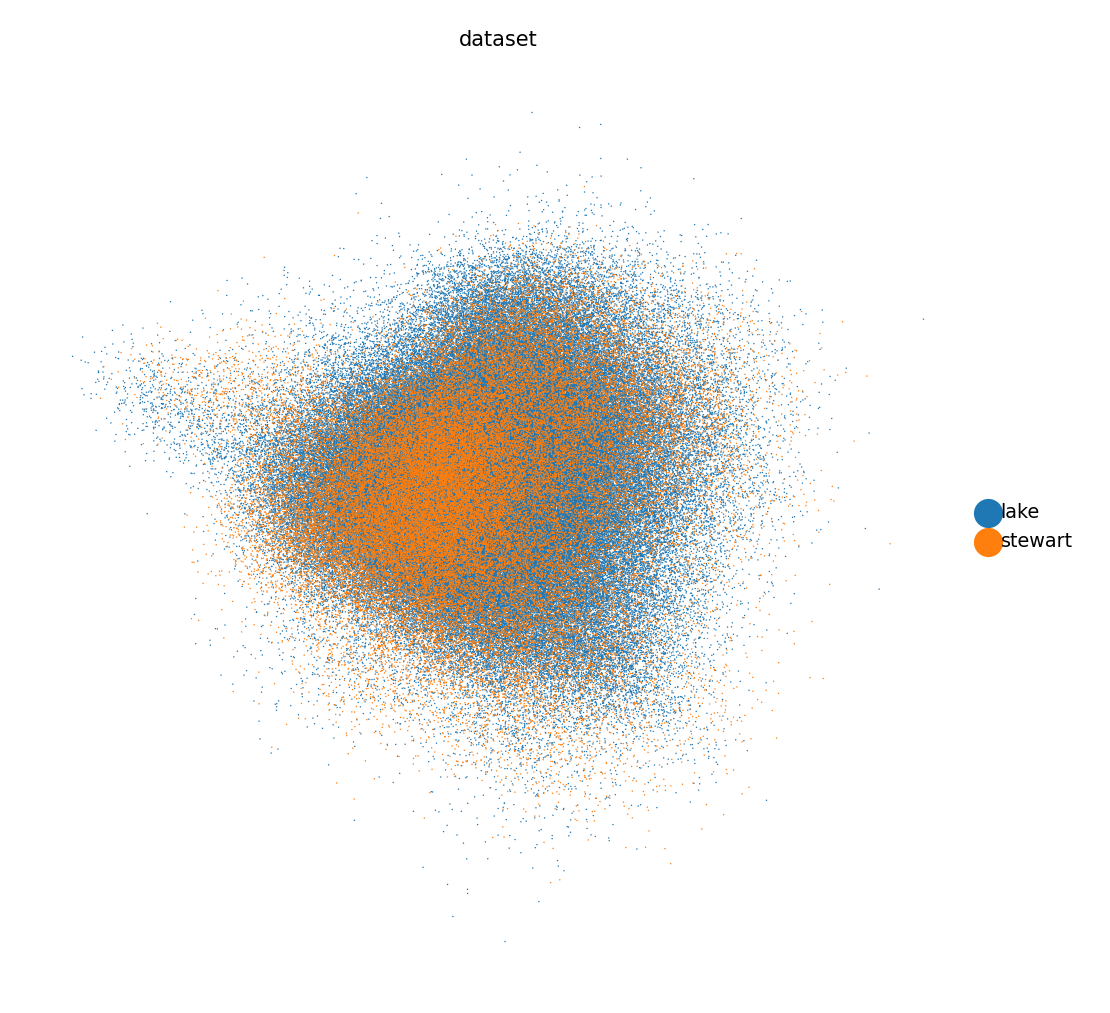

In [26]:
sc.pl.embedding(joint_adata, basis = "X_scVI", color = 'dataset')

In [27]:
sc.pp.neighbors(joint_adata, use_rep = 'X_scVI')

In [29]:
sc.tl.umap(joint_adata)

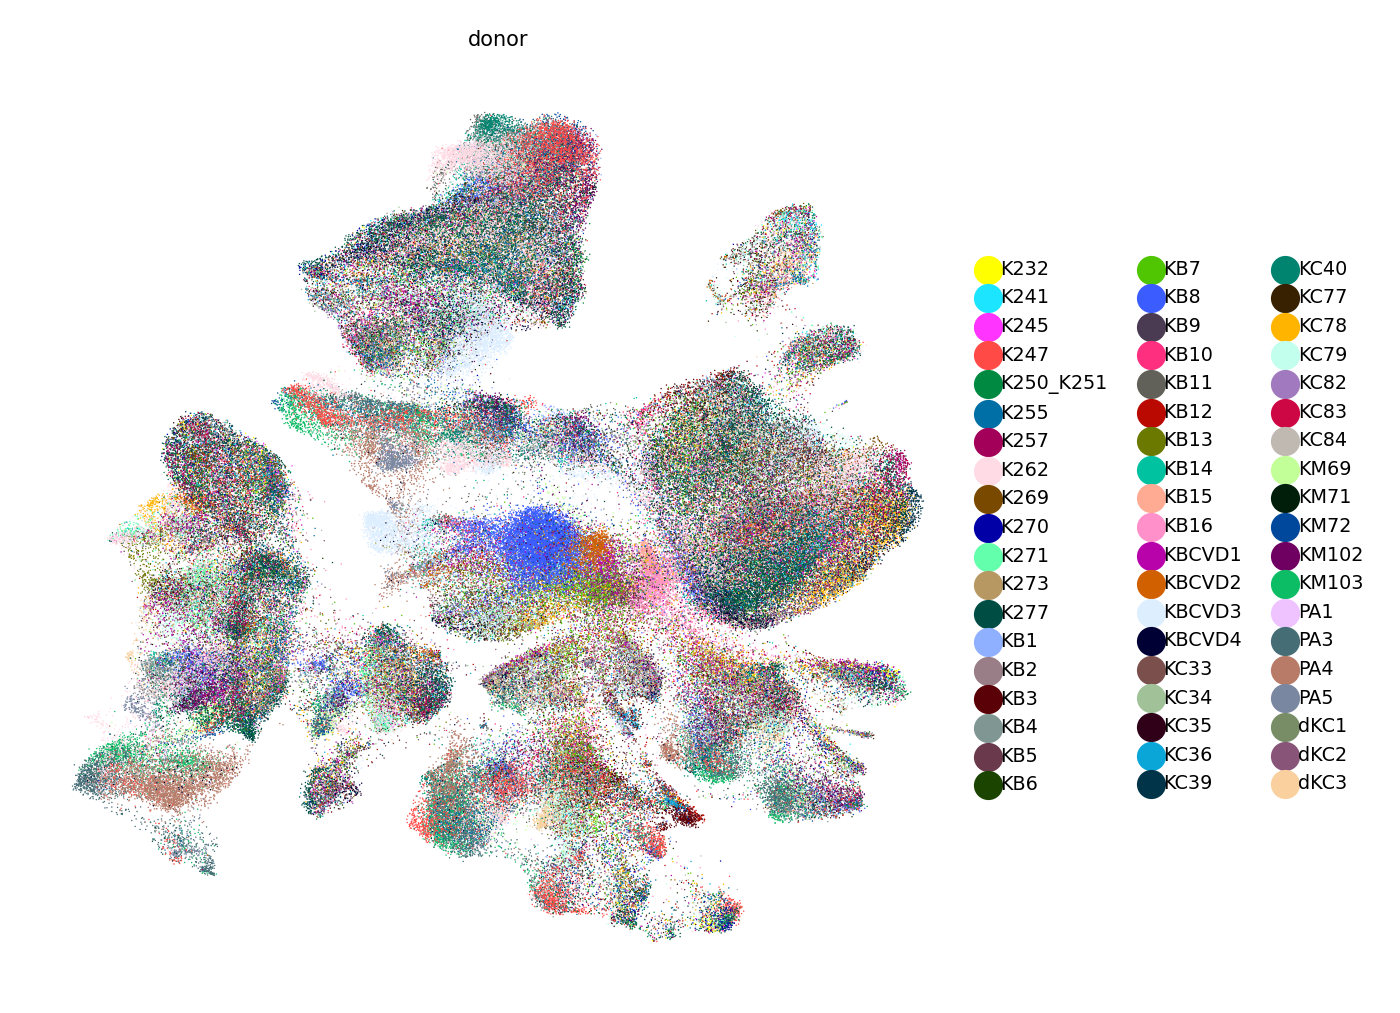

In [33]:
sc.pl.umap(joint_adata, color = 'donor')

In [3]:
#single cells 
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response')
cell_data = sc.read_h5ad("./data/annotated/scRNAseq_glom_TI_kidney.h5ad")

In [4]:
def get_counts_raw(adata):
    adata_counts = adata.uns['raw_adata'].copy()
    adata_counts = adata_counts[adata.obs_names]
    adata = adata.raw.to_adata()
    adata.layers = adata_counts.layers.copy()
    return(adata)
cell_data = get_counts_raw(cell_data)

In [6]:
#exclude the core exclude genes
cell_data = cell_data[:,cell_data.var.core_exclude]

In [8]:
cell_data.obs['tissue']

AAACCCATCCTTCACG-1_cellranger700_count_33883_CG_SB_NB8768284_GRCh38-2020-A        Glomerulus_single_cell_suspension
AAACGAACAATTGGTC-1_cellranger700_count_33883_CG_SB_NB8768284_GRCh38-2020-A        Glomerulus_single_cell_suspension
AAACGAAGTATAATGG-1_cellranger700_count_33883_CG_SB_NB8768284_GRCh38-2020-A        Glomerulus_single_cell_suspension
AAACGCTAGGATACAT-1_cellranger700_count_33883_CG_SB_NB8768284_GRCh38-2020-A        Glomerulus_single_cell_suspension
AAACGCTGTAGAGACC-1_cellranger700_count_33883_CG_SB_NB8768284_GRCh38-2020-A        Glomerulus_single_cell_suspension
                                                                                              ...                  
TTTGTTGGTAGAGATT-1_cellranger700_count_46409_KID_CZI13249527_GRCh38-2020-A    TI_compartment_single_cell_suspension
TTTGTTGGTGTCCGTG-1_cellranger700_count_46409_KID_CZI13249527_GRCh38-2020-A    TI_compartment_single_cell_suspension
TTTGTTGTCAATGCAC-1_cellranger700_count_46409_KID_CZI13249527_GRCh38-2020

In [7]:
#lake cells
lake_cell_adata = sc.read_h5ad("./data/public_data/lake_2023/lake_SCrnaseq.h5ad")
del lake_cell_adata.obs['laterality'] #causing some true false boolean problems!

In [12]:
lake_cell_adata.obs['tissue'] = 'kidney_single_cell_suspension'

In [ ]:
#add compartment information

In [13]:
cell_data.obs['dataset'] = 'stewart'
lake_cell_adata.obs['dataset'] = 'lake'
lake_cell_adata.obs['donor'] = lake_cell_adata.obs['library']

In [25]:
#what cell types do we have in lake
np.array(pd.crosstab(lake_cell_adata.obs['dataset'], lake_cell_adata.obs['subclass.full']))

array([[   48, 10315,  5486,   961,   427,  1091,  1298,    31,  2637,
          410,  2021,  2835,   610, 13849,    20,    76,   165,   423,
         1623,  2382,   493,  4356,    11,   217,   328,  6299,   185,
         6879,  1247,  1206,   557,    55,   830,   452,   248,    87,
         1490,   139,  1274,   113,   848,  2051,    65,     6,   511,
           64,  2521,     9,  3644,   599,  1839,   209,   203,   202,
          992,  3164,   715,    92,  5933,   809,    45,     5,  4132,
          979,    87,  1416]])

In [26]:
cell_data.layers['counts'] = cell_data.layers['raw_counts']

In [27]:
joint_adata = sc.concat([lake_cell_adata, cell_data])

In [28]:
# Compute HVG per batch
nvar = 3000
sc.pp.highly_variable_genes(joint_adata, n_top_genes = nvar, flavor='seurat_v3', subset = False, 
                            layer = 'counts',
                           batch_key = 'dataset')
# Sort by how many times a gene is marked as HVG and select top genes
hvg = joint_adata.var.sort_values('highly_variable_nbatches').tail(nvar).index
# Update gene's metadata
joint_adata.var['highly_variable'] = [g in hvg for g in joint_adata.var.index]

In [29]:
joint_adata.uns['raw_adata'] = joint_adata.copy() #this lets us get the rawcounts later

In [30]:
#normalise and log transform
sc.pp.normalize_total(joint_adata)
sc.pp.log1p(joint_adata)
#then we can use raw for plotting

In [31]:
joint_adata.raw = joint_adata.copy()

In [32]:
#subset to HVG
joint_adata = joint_adata[:, joint_adata.var['highly_variable']]


In [33]:
#calculate PCA
sc.pp.pca(joint_adata)

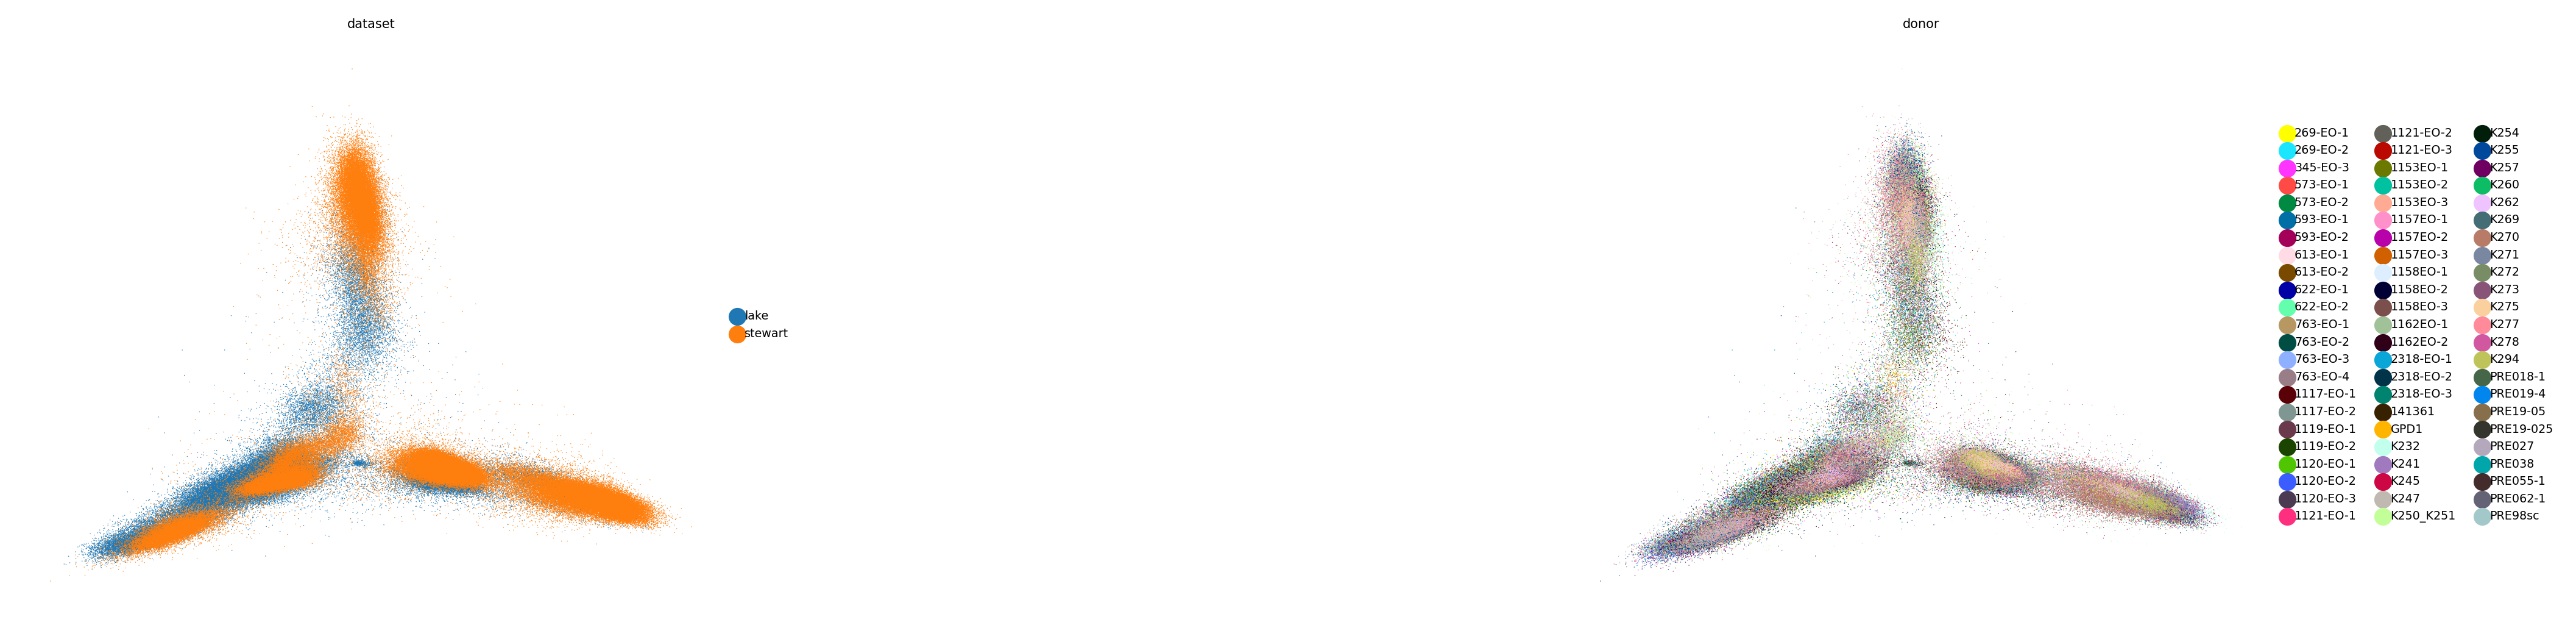

In [34]:
sc.pl.pca(joint_adata, color = ['dataset', 'donor'],
          wspace = 1)

In [35]:
joint_adata = joint_adata.copy()

In [37]:
#setup an SCVI model
scvi.model.SCVI.setup_anndata(joint_adata, 
                           categorical_covariate_keys = ['dataset', 'donor', 'tissue'],
                              layer = 'counts')

In [38]:
vae = sca.models.SCVI(joint_adata, 
                      n_latent =15, 
                      n_layers = 2, 
                encode_covariates=True,
                deeply_inject_covariates=False,
                use_layer_norm="both",
                use_batch_norm="none",

                      gene_likelihood = 'nb')

In [39]:
vae.view_anndata_setup(joint_adata)

Anndata setup with scvi-tools version 0.19.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': None,
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['dataset', 'donor', 'tissue'],
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │ 279085 │
│ n_extra_categorical_covs │   3    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │  3000  │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │           adata.layers['counts']           │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                        extra_categorical_covs State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃              Categories               ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['dataset'] │                 lake                  │          0          │
│                      │                stewart                │          1          │
│                      │                                       │                     │
│  adata.obs['donor']  │               269-EO-1                │          0          │
│                      │               269-EO-2                │          1          │
│                      │               345-EO-3                │          2          │
│                      │               573-EO-1                │          3          │
│                      │               573-EO-2                │          4          │
│                      │               593-EO-1                │          5          │
│                      │               593-EO-2                │          6          │
│                      │               613-EO-1                │          7          │
│                      │               613-EO-2                │          8          │
│                      │               622-EO-1                │          9          │
│                      │               622-EO-2                │         10          │
│                      │               763-EO-1                │         11          │
│                      │               763-EO-2                │         12          │
│                      │               763-EO-3                │         13          │
│                      │               763-EO-4                │         14          │
│                      │               1117-EO-1               │         15          │
│                      │               1117-EO-2               │         16          │
│                      │               1119-EO-1               │         17          │
│                      │               1119-EO-2               │         18          │
│                      │               1120-EO-1               │         19          │
│                      │               1120-EO-2               │         20          │
│                      │               1120-EO-3               │         21          │
│                      │               1121-EO-1               │         22          │
│                      │               1121-EO-2               │         23          │
│                      │               1121-EO-3               │         24          │
│                      │               1153EO-1                │         25          │
│                      │               1153EO-2                │         26          │
│                      │               1153EO-3                │         27          │
│                      │               1157EO-1                │         28          │
│                      │               1157EO-2                │         29          │
│                      │               1157EO-3                │         30          │
│                      │               1158EO-1                │         31          │
│                      │               1158EO-2                │         32          │
│                      │               1158EO-3                │         33          │
│                      │               1162EO-1                │         34          │
│                      │               1162EO-2                │         35          │
│                      │               2318-EO-1               │         36          │
│                      │               2318-EO-2               │         37          │
│                      │               2318-EO-3               │         38          

In [40]:
vae.train(early_stopping = True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 29/29: 100%|██████████████████████████| 29/29 [13:51<00:00, 28.64s/it, loss=519, v_num=1]

`Trainer.fit` stopped: `max_epochs=29` reached.


Epoch 29/29: 100%|██████████████████████████| 29/29 [13:51<00:00, 28.67s/it, loss=519, v_num=1]


In [41]:
joint_adata.obsm['X_scVI'] = vae.get_latent_representation()

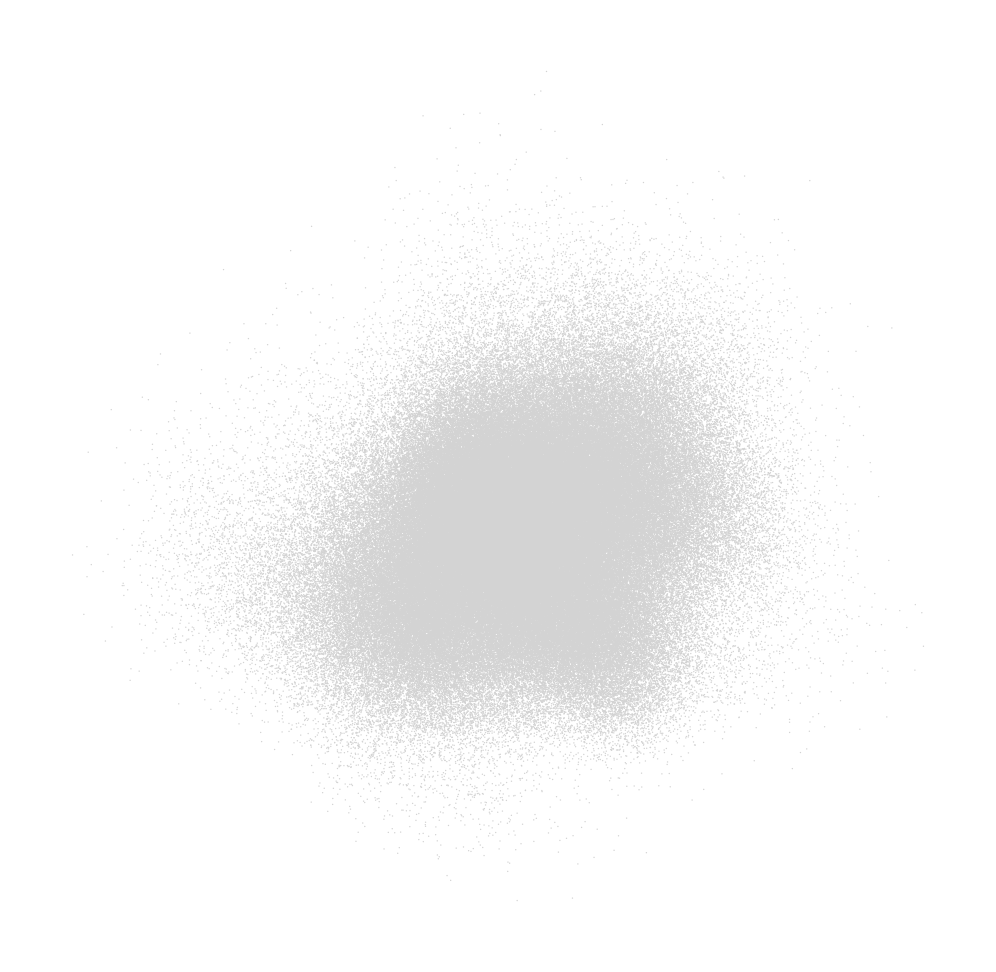

In [42]:
sc.pl.embedding(joint_adata, basis = "X_scVI")

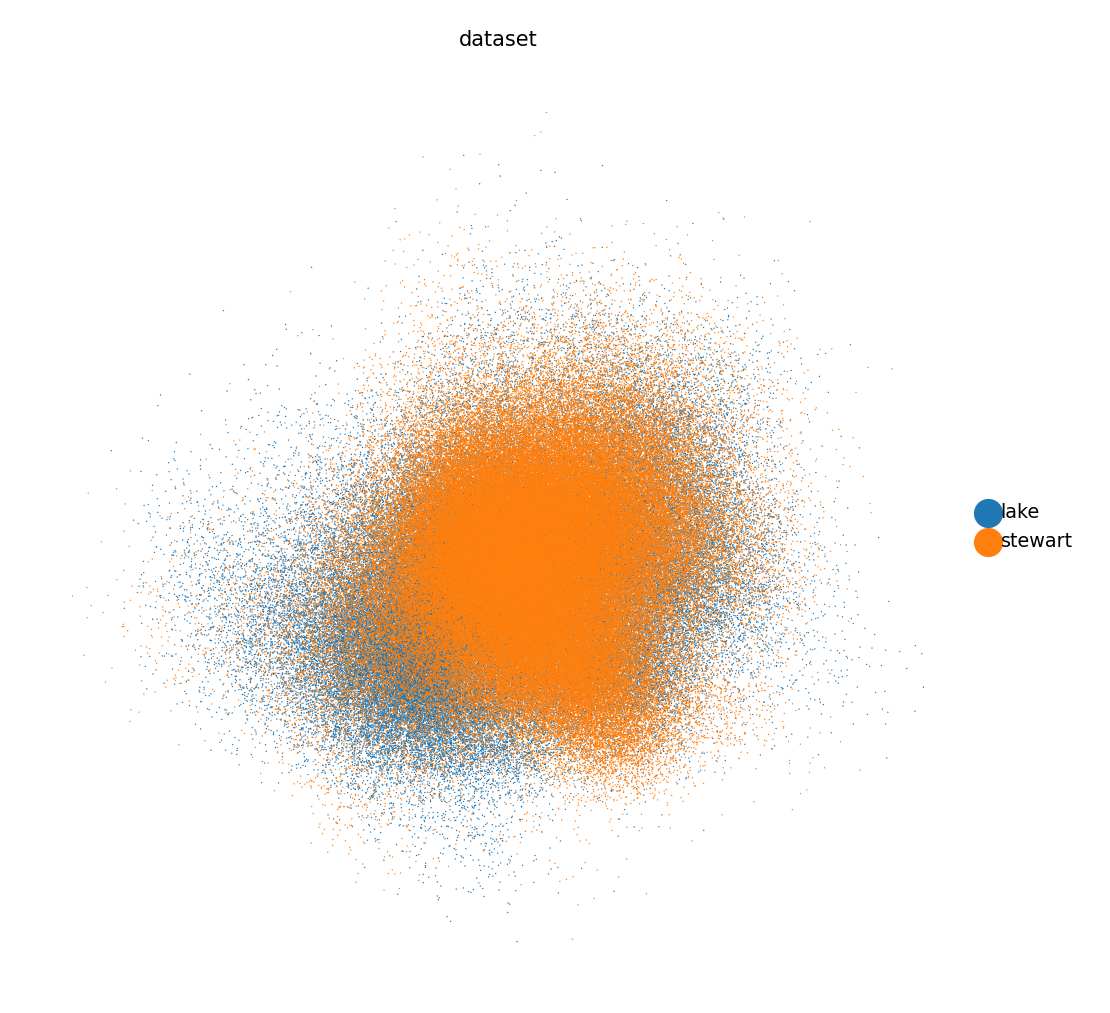

In [43]:
sc.pl.embedding(joint_adata, basis = "X_scVI", color = 'dataset')

In [44]:
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data/trained/public_data')
vae.save("lake_cells/", overwrite=True, save_anndata = True)